### Dados de Saúde SP

In [95]:
import pandas as pd

dataSaude = pd.read_csv(r"C:\Users\wever\Documents\GitHub\IniciacaoCientifica1\Dados\dados_saude_SP.csv")

C:\Users\wever\AppData\Local\Temp\ipykernel_8712\401097701.py:3: DtypeWarning: Columns (4,6,12,21,23,25,60,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  dataSaude = pd.read_csv(r"C:\Users\wever\Documents\GitHub\IniciacaoCientifica1\Dados\dados_saude_SP.csv")


In [107]:
# Agrupando por dataNotificacao e sintomas e contando as ocorrências
dataSaude['dataNotificacao'] = pd.to_datetime(dataSaude['dataNotificacao'])

# Separar os sintomas compostos e expandir para várias linhas
dataSaude['sintomas'] = dataSaude['sintomas'].str.split(',')  # Dividir sintomas compostos por vírgula
dataSaude = dataSaude.explode('sintomas')  # Expandir para múltiplas linhas por sintoma


# Filtrando os sintomas desejados
sintomas_desejados = ['Tosse', 'Coriza', 'Dor de Cabeça']
df_filtrado = dataSaude[dataSaude['sintomas'].isin(sintomas_desejados)]

# Agrupando por dataNotificacao e sintomas e contando as ocorrências
df_sintomas = df_filtrado.groupby([df_filtrado['dataNotificacao'].dt.date, 'sintomas']).size().reset_index(name='contagem')

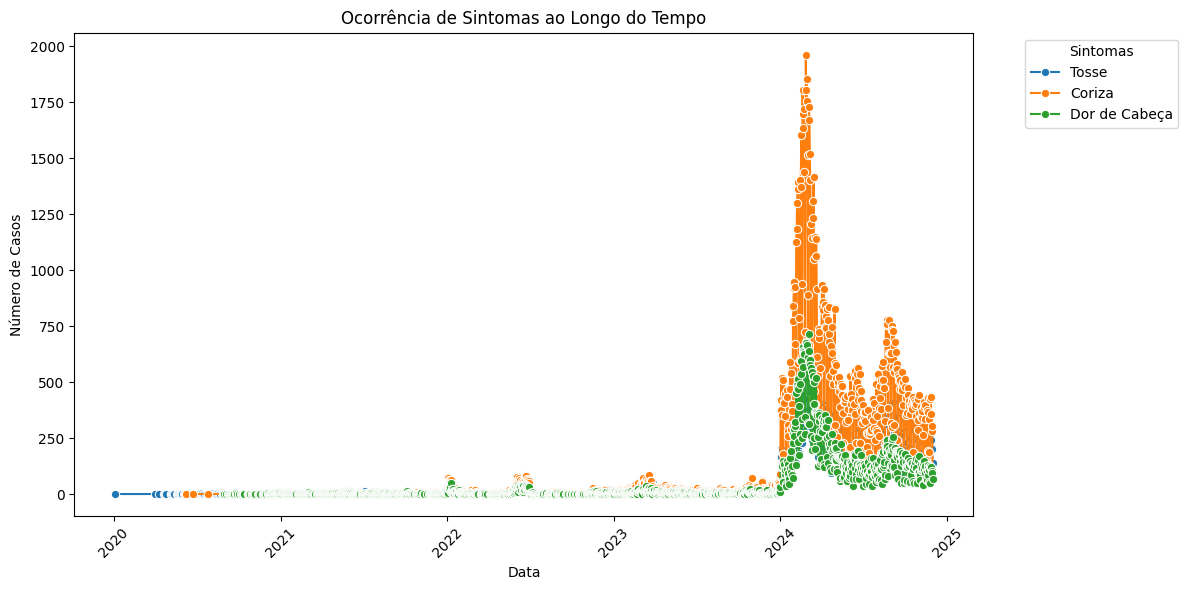

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotando o número de casos de sintomas ao longo do tempo
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_sintomas, x='dataNotificacao', y='contagem', hue='sintomas', marker='o')

# Adicionando título e rótulos
plt.title('Ocorrência de Sintomas ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Número de Casos')
plt.xticks(rotation=45)
plt.legend(title='Sintomas', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Filtrando apenas as colunas necessárias
df_exportar = df_filtrado[['dataNotificacao', 'sintomas']]

# Salvando o DataFrame em um arquivo CSV
#df_exportar.to_csv('principais_sintomas.csv', index=False)

In [ ]:
import pymysql
import csv
from datetime import datetime

# Conexão com o banco de dados
connection = pymysql.connect(
    host='localhost',
    user='root',
    password='525748',
    database='bd_medicao'
)


def process_principais_sintomas(file_path):
    with open(file_path, encoding='utf-8') as csv_file:
        csv_data = csv.reader(csv_file)
        next(csv_data)  # Ignora o cabeçalho

        cursor = connection.cursor()
        for row in csv_data:
            try:
                # Verificar e ajustar o formato da data
                if len(row[0]) == 10:  # Formato YYYY-MM-DD
                    data_notificacao = datetime.strptime(row[0], '%Y-%m-%d').strftime('%Y-%m-%d %H:%M:%S')
                else:
                    raise ValueError(f"Formato de data inesperado: {row[0]}")

                # Campo de sintomas
                sintomas = row[1]

                # Inserir no banco de dados
                cursor.execute("""
                    INSERT INTO principais_sintomas (data_notificacao, sintomas)
                    VALUES (%s, %s)
                """, (data_notificacao, sintomas))
            except Exception as e:
                print(f"Erro ao processar linha: {row}. Erro: {e}")

        connection.commit()
        
#process_principais_sintomas('C:/Users/wever/Documents/GitHub/IniciacaoCientifica/Database/principais_sintomas.csv')

#### Dados de CO SP

In [25]:
import pandas as pd

dataCO = pd.read_csv(r"C:\Users\wever\Documents\GitHub\IniciacaoCientifica\ETL\Dados_CO_SP.csv")

In [ ]:
dataCO = dataCO.rename(columns={"Hora":"Data da Coleta", "Código Estação":"Hora da coleta", "Nome Parâmetro":"Medida", "Unidade de Medida":"Média do horário"})

dadosExportar = dataCO[["Data da Coleta","Hora da coleta","Medida","Média do horário"]]

#dadosExportar.to_csv('dados_CO.csv', index=False)

In [ ]:
import pymysql
import csv
from datetime import datetime, timedelta

# Conexão com o banco de dados
connection = pymysql.connect(
    host='localhost',
    user='root',
    password='525748',
    database='bd_medicao'
)

# Abrindo o arquivo CSV e inserindo dados
#with open('C:/Users/wever/Documents/GitHub/IniciacaoCientifica/Database/dados_CO.csv', encoding='utf-8') as csv_file:
    csv_data = csv.reader(csv_file)
    next(csv_data)  # Ignora o cabeçalho

    cursor = connection.cursor()
    for row in csv_data:
        try:
            # Ajustar o formato da data
            data_da_coleta = datetime.strptime(row[0], '%d/%m/%Y')

            # Tratar hora da coleta, incluindo ajuste para 24:00
            hora_da_coleta_raw = row[1]
            if hora_da_coleta_raw == '24:00':
                hora_da_coleta_raw = '00:00'
                data_da_coleta += timedelta(days=1)  # Ajusta a data para o próximo dia

            # Adicionar segundos, se necessário
            if len(hora_da_coleta_raw.split(':')) == 2:  # Formato HH:MM
                hora_da_coleta_raw += ":00"
            hora_da_coleta = datetime.strptime(hora_da_coleta_raw, '%H:%M:%S').strftime('%H:%M:%S')

            # Combinar data e hora para o formato DATETIME
            datetime_hora_da_coleta = f"{data_da_coleta.strftime('%Y-%m-%d')} {hora_da_coleta}"

            # Outros campos
            medida = row[2]

            # Substituir vírgulas por pontos no valor float
            media_do_horario = float(row[3].replace(',', '.'))

            # Inserir no banco de dados
            cursor.execute("""
                INSERT INTO dados_CO (data_da_coleta, hora_da_coleta, medida, media_do_horario) 
                VALUES (%s, %s, %s, %s)
            """, (datetime_hora_da_coleta, datetime_hora_da_coleta, medida, media_do_horario))
        except Exception as e:
            print(f"Erro ao processar linha: {row}. Erro: {e}")

    connection.commit()

connection.close()

#### Dados de temperatura SP

In [3]:
import pandas as pd

dataTemp = pd.read_csv(r"C:\Users\wever\Documents\GitHub\IniciacaoCientifica\ETL\dados_brasil_Temp.csv")

In [ ]:
dadosTemperatura = dataTemp[dataTemp["City"] == "São Paulo"]

#dadosTemperatura = dadosTemperatura.to_csv('dados_temperatura_SP.csv', index=False)

In [ ]:
import pymysql
import csv
from datetime import datetime

# Conexão com o banco de dados
connection = pymysql.connect(
    host='localhost',
    user='root',
    password='525748',
    database='bd_medicao'
)

def process_dados_temperatura_SP(file_path):
    with open(file_path, encoding='utf-8') as csv_file:
        csv_data = csv.reader(csv_file)
        next(csv_data)  # Ignora o cabeçalho

        cursor = connection.cursor()
        for row in csv_data:
            try:
                # Verificar e ajustar o formato da data
                if len(row[0]) == 10:  # Formato YYYY-MM-DD
                    date = datetime.strptime(row[0], '%Y-%m-%d').strftime('%Y-%m-%d %H:%M:%S')
                else:
                    raise ValueError(f"Formato de data inesperado: {row[0]}")

                # Outros campos
                country = row[1]
                city = row[2]
                count = int(row[4])
                min_temp = float(row[5].replace(',', '.'))
                max_temp = float(row[6].replace(',', '.'))
                median = float(row[7].replace(',', '.'))
                variance = float(row[8].replace(',', '.'))

                # Inserir no banco de dados
                cursor.execute("""
                    INSERT INTO dados_temperatura_SP (date, country, city, count, min, max, median, variance)
                    VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
                """, (date, country, city, count, min_temp, max_temp, median, variance))
            except Exception as e:
                print(f"Erro ao processar linha: {row}. Erro: {e}")

        connection.commit()

#process_dados_temperatura_SP('C:/Users/wever/Documents/GitHub/IniciacaoCientifica/Database/dados_temperatura_SP.csv')


#### Dados Sensores

In [1]:
import pymysql
import csv
from datetime import datetime

# Conexão com o banco de dados
connection = pymysql.connect(
    host='localhost',
    user='root',
    password='senai@134',
    database='bd_medicao'
)

def insert_batch(file_path):
    with open(file_path, encoding='utf-8') as csv_file:
        csv_data = csv.reader(csv_file, delimiter=';')
        next(csv_data)  # Ignorar o cabeçalho

        cursor = connection.cursor()
        batch_size = 1000  # Define o tamanho do lote
        batch = []

        for row in csv_data:
            try:
                # Substituir vírgulas por pontos para valores decimais
                temperatura = float(row[0].replace(',', '.'))
                pressao = float(row[1].replace(',', '.'))
                altitude = float(row[2].replace(',', '.'))

                # Tratar "NULL" e converter para None
                umidade = None if row[3].strip().upper() == "NULL" else int(row[3])
                co2 = None if row[4].strip().upper() == "NULL" else float(row[4].replace(',', '.'))
                tempo_registro = datetime.strptime(row[5], '%d/%m/%Y %H:%M').strftime('%Y-%m-%d %H:%M:%S')
                regiao = row[6]

                # Adicionar os valores ao lote
                batch.append((temperatura, pressao, altitude, umidade, co2, tempo_registro, regiao))

                # Insere o lote quando atinge o tamanho definido
                if len(batch) >= batch_size:
                    cursor.executemany("""
                        INSERT INTO tb_registro (temperatura, pressao, altitude, umidade, co2, tempo_registro, regiao)
                        VALUES (%s, %s, %s, %s, %s, %s, %s)
                    """, batch)
                    connection.commit()
                    batch = []  # Limpa o lote
            except Exception as e:
                print(f"Erro ao processar linha: {row}. Erro: {e}")

        # Insere o restante dos dados
        if batch:
            cursor.executemany("""
                INSERT INTO tb_registro (temperatura, pressao, altitude, umidade, co2, tempo_registro, regiao)
                VALUES (%s, %s, %s, %s, %s, %s, %s)
            """, batch)
            connection.commit()

        print("Importação concluída com sucesso!")

# Caminho para o arquivo CSV
file_path = r'C:\Users\50749314877\Desktop\Git\IniciacaoCientifica\ETL\Arquivos\dadosSensores.csv'

# Executar a função
insert_batch(file_path)

# Fechar a conexão com o banco de dados
connection.close()

Importação concluída com sucesso!
